# SC1015 DSAI Mini Project
## Part 5: Model 4
---
In this section we will perform model training on the top 5 variables from our cleaned dataset. So far, the most successful  model has been Random Forest. To build on this, we look at XGBoost. XGBoost employs gradient boosting, a machine learning technique which gives a prediction model in the form on an ensemble of decision trees. However in addition to gradient boosting, xgboosthas regularization which prevents overfitting in the model. It has an extra randomisation parameter can be used to reduce the correlation between the trees, the lesser the correlation among classifiers, the better our ensemble of classifiers will turn out.

**Question:** Can we detect phishing websites from benign ones using their respective URLs?

In [1]:
import numpy as np
import pandas as pd# Import cleaned dataset
import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics

import matplotlib.pyplot as plt # we only need pyplot
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("cleaned_data.csv",index_col=0)
df.shape
df.head()

,url,phish,use_of_ip,short_url,uses-https,uses-http,count.,count@,count_dir,count_embed_domain,count%,count?,count-,count=,url_length,hostname_length,count-digits,count-letters,url_entropy
0,https://obmen.click/,phishing,not IP,original,https,http,1,0,1,0,0,0,0,0,20,11,0,15,3.884184
1,https://neueinrichtung-sparkasse.de/,phishing,not IP,original,https,http,1,0,1,0,0,0,1,0,36,27,0,30,3.995907
2,https://3db32516c1b476e7eff40e2d8ff8d9d7.krokl...,phishing,not IP,original,https,http,3,0,5,0,0,0,0,0,100,45,36,53,4.711532
3,https://f0d89a41642e0026589577e0e13d9d58.krokl...,phishing,not IP,original,https,http,3,0,5,0,0,0,0,0,100,45,42,47,4.743081
4,https://ratnes.com/,phishing,not IP,original,https,http,1,0,1,0,0,0,0,0,19,10,0,14,3.642150


In [3]:
#One hot encoding for categorical variables
df["uses-http"]=df["uses-http"].astype("category")
df["uses-https"]=df["uses-https"].astype("category")
df["uses-http"] = df["uses-http"].cat.rename_categories([0, 1])
df["uses-https"] = df["uses-https"].cat.rename_categories([0, 1])
df

,url,phish,use_of_ip,short_url,uses-https,uses-http,count.,count@,count_dir,count_embed_domain,count%,count?,count-,count=,url_length,hostname_length,count-digits,count-letters,url_entropy
0,https://obmen.click/,phishing,not IP,original,0,0,1,0,1,0,0,0,0,0,20,11,0,15,3.884184
1,https://neueinrichtung-sparkasse.de/,phishing,not IP,original,0,0,1,0,1,0,0,0,1,0,36,27,0,30,3.995907
2,https://3db32516c1b476e7eff40e2d8ff8d9d7.krokl...,phishing,not IP,original,0,0,3,0,5,0,0,0,0,0,100,45,36,53,4.711532
3,https://f0d89a41642e0026589577e0e13d9d58.krokl...,phishing,not IP,original,0,0,3,0,5,0,0,0,0,0,100,45,42,47,4.743081
4,https://ratnes.com/,phishing,not IP,original,0,0,1,0,1,0,0,0,0,0,19,10,0,14,3.642150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730184,http://www.adnet8.com/image/caseimage/?http://...,phishing,not IP,original,1,0,6,0,3,0,0,2,1,2,128,14,3,94,4.479253
730185,http://gkjx168.com/images/,phishing,not IP,original,1,0,1,0,2,0,0,0,0,0,26,11,3,17,4.161978
730186,http://www.gkjx168.com/images/,phishing,not IP,original,1,0,2,0,2,0,0,0,0,0,30,15,3,20,4.215061
730187,http://blazeygraphicsystems.com/classifieds/no...,phishing,not IP,original,1,0,2,0,3,0,0,0,0,0,69,24,0,61,4.177618


In [4]:
#Repeat for y
df["phish"]=df["phish"].astype("category")
df["phish"] = df["phish"].cat.rename_categories([0, 1])

In [5]:
df_num = df[['uses-http','uses-https','hostname_length','count.','count_dir']]
df_res = df['phish']
df_final = pd.concat([df_num,df_res],sort=False,axis=1).reindex(index=df_num.index)
#Check final dataframe
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730189 entries, 0 to 730188
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   uses-http        730189 non-null  category
 1   uses-https       730189 non-null  category
 2   hostname_length  730189 non-null  int64   
 3   count.           730189 non-null  int64   
 4   count_dir        730189 non-null  int64   
 5   phish            730189 non-null  category
dtypes: category(3), int64(3)
memory usage: 24.4 MB


In [6]:
# Extract Response and Predictors
y = pd.DataFrame(df_final['phish'])
X = pd.DataFrame(df_final.drop('phish', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [7]:
gb = XGBClassifier(tree_method="gpu_hist", enable_categorical=True)
gb.fit(X_train, y_train.phish.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Train Data
Accuracy  :	 0.8583438329042204

TPR Train :	 0.7194803577543841
TNR Train :	 0.9674066053059015

FPR Train :	 0.03259339469409854
FNR Train :	 0.28051964224561593


<AxesSubplot:>

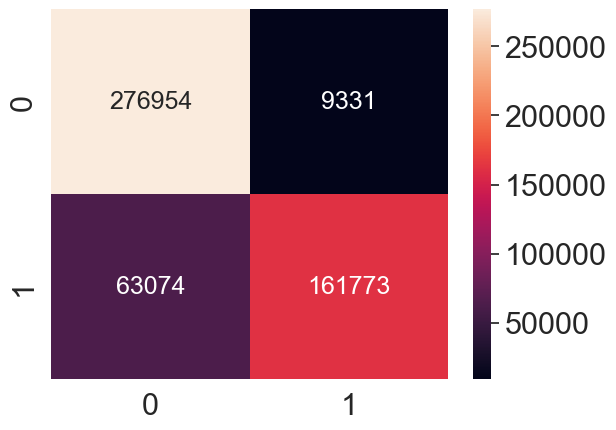

In [8]:
# Predict the Response corresponding to Predictors
y_train_pred = gb.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", gb.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8588175680302387

TPR Test :	 0.7214279068324908
TNR Test :	 0.9674563468707083

FPR Test :	 0.03254365312929174
FNR Test :	 0.27857209316750925


<AxesSubplot:>

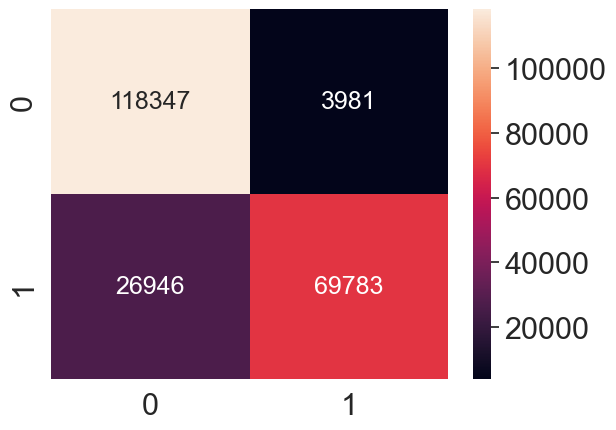

In [9]:
# Predict the Response corresponding to Predictors
y_test_pred = gb.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", gb.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [10]:
# Extract Response and Predictors
y = pd.DataFrame(df_final['phish'])
X = pd.DataFrame(df_final.drop('phish', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [12]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 1]
}

In [14]:
gb=RandomizedSearchCV(XGBClassifier(tree_method="gpu_hist", enable_categorical=True),param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
gb.fit(X_train, y_train.phish.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                           monotone_constraints=None,
                         

In [16]:
print(gb.best_params_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(gb.best_score_))

{'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 1}
0.8583673135859791


Train Data
Accuracy  :	 0.858482740270615

TPR Train :	 0.7235478813879229
TNR Train :	 0.9647329530950025

FPR Train :	 0.03526704690499753
FNR Train :	 0.276452118612077


<AxesSubplot:>

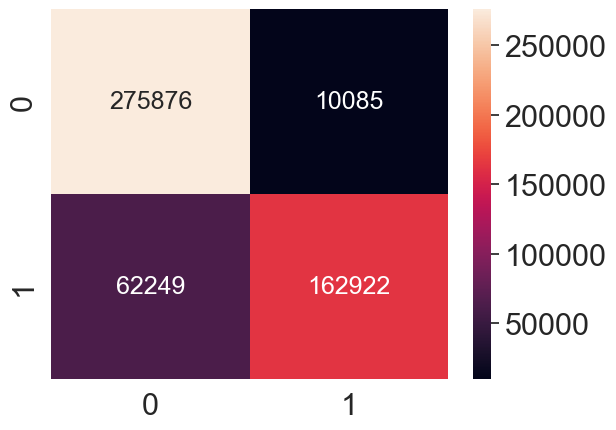

In [18]:
# Predict the Response corresponding to Predictors
y_train_pred = gb.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", gb.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8591782047594918

TPR Test :	 0.7241118199263523
TNR Test :	 0.9653409646805596

FPR Test :	 0.03465903531944037
FNR Test :	 0.2758881800736476


<AxesSubplot:>

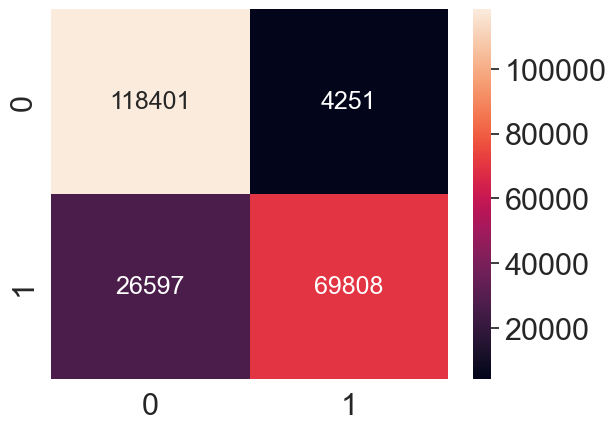

In [20]:
# Predict the Response corresponding to Predictors
y_test_pred = gb.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", gb.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

## Attempt 4: XGBoost Conclusion
After parameter tuning, with XGBoost, we are able to achieve an accuracy of 0.8592, the highest of all 4 models.